In [0]:
# Taken from https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=xytAr_C48wnu
# and from TAD lab 4 The University of Glasgow.

In [2]:
local_file = "reviews_Apps_for_Android_5.json.gz"
!curl -o  $local_file https://storage.googleapis.com/tad2018/reviews_Apps_for_Android_5.json.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91.0M  100 91.0M    0     0  54.7M      0  0:00:01  0:00:01 --:--:-- 54.7M


In [3]:
!pip install transformers

     |████████████████████████████████| 501kB 2.6MB/s 
     |████████████████████████████████| 870kB 9.0MB/s 
     |████████████████████████████████| 1.0MB 19.2MB/s 
     |████████████████████████████████| 3.7MB 21.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=67417450e50a25ebef6d8cda779985bf9776517fea13e840d8e1a83695e3e435
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


In [4]:
import gzip
import json
import pandas as pd

review_list = list()

# Construct a dataframe, by opening the JSON file line-by-line
with gzip.open(local_file) as jsonfile:
  for i, line in enumerate(jsonfile):
    review = json.loads(line)
    #print(review)
    #if (i >= review_limit): break
    # asin is the product number, overall is the number of stars awarded by the user for that product
    review_list.append( (review['asin'], review['reviewerID'], review['reviewText'], review['summary'], review['overall']))
                   
print("We have %d reviews in our dataset"  % len(review_list))

collabels = ['productId', 'reviewerID', 'reviewText', 'summary', 'overall']
reviews = pd.DataFrame(review_list, columns=collabels)

We have 752937 reviews in our dataset


In [5]:
reviews.head()

,productId,reviewerID,reviewText,summary,overall
0,B004A9SDD8,A1N4O8VOJZTDVB,"Loves the song, so he really couldn't wait to ...",Really cute,3.0
1,B004A9SDD8,A2HQWU6HUKIEC7,"Oh, how my little grandson loves this app. He'...",2-year-old loves it,5.0
2,B004A9SDD8,A1SXASF6GYG96I,I found this at a perfect time since my daught...,Fun game,5.0
3,B004A9SDD8,A2B54P9ZDYH167,My 1 year old goes back to this game over and ...,We love our Monkeys!,5.0
4,B004A9SDD8,AFOFZDTX5UC6D,There are three different versions of the song...,This is my granddaughters favorite app on my K...,5.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5cd303898>]],
      dtype=object)

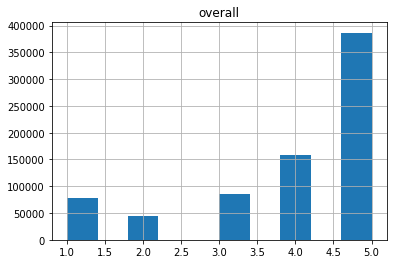

In [6]:
reviews.hist('overall')

## Now adding a class column to the reviews DF. This column contains 1 for positive ratings (>3) and 0 otherwise

In [7]:
def create_label(label):
    if label >3:
        return 1
    else:
        return 0
reviews['Class']=reviews['overall'].apply(create_label)

print(reviews.head(20))


     productId      reviewerID  ... overall Class
0   B004A9SDD8  A1N4O8VOJZTDVB  ...     3.0     0
1   B004A9SDD8  A2HQWU6HUKIEC7  ...     5.0     1
2   B004A9SDD8  A1SXASF6GYG96I  ...     5.0     1
3   B004A9SDD8  A2B54P9ZDYH167  ...     5.0     1
4   B004A9SDD8   AFOFZDTX5UC6D  ...     5.0     1
5   B004A9SDD8  A331GYAT4ESYI3  ...     5.0     1
6   B004A9SDD8  A2YEHF8T823TDC  ...     5.0     1
7   B004A9SDD8  A3699WHISXX94Z  ...     5.0     1
8   B004A9SDD8  A2BXV49EIES2TB  ...     5.0     1
9   B004A9SDD8  A37HM5TMCMHJES  ...     5.0     1
10  B004A9SDD8  A1FYZPJLU78R2Y  ...     4.0     1
11  B004A9SDD8   AV58L39SOERMI  ...     3.0     0
12  B004A9SDD8  A31XG60B64OW74  ...     5.0     1
13  B004A9SDD8  A39JZ61LPIVY91  ...     3.0     0
14  B004A9SDD8   AIRKROQMCBVG4  ...     5.0     1
15  B004A9SDD8   AELVL0VXR3VFN  ...     5.0     1
16  B004A9SDD8   A55641MA1CS5F  ...     4.0     1
17  B004AFQAUA  A39TLD5D8M76M4  ...     1.0     0
18  B004AFQAUA  A2XJJKZSEYYW8T  ...     5.0     1


### Loading Bert's tokenizer:

In [11]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [12]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


In [13]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
# shuffle the data randomly to avoid possible bias.
random_reviews = reviews.sample(frac=1)

# The min limits the size of the dataset loaded to 100k, 1/8 of the total data. 
# It's set to not be "too big" for this lab. 
review_limit = min(50000, len(random_reviews))
random_reviews = random_reviews.iloc[:review_limit, :]

In [9]:
random_reviews.shape

(50000, 6)

## Tokenizing the reviewText column

In [0]:
# https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=2bBdb3pt8LuQ
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
sentences = random_reviews.reviewText.values
# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                         max_length =    128     # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

In [0]:
#input_ids #is 2 D list where every element is a list denoting a tokenized sentence

## padding the reviewtext column

In [17]:
## https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=2bBdb3pt8LuQ
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 150

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

Using TensorFlow backend.



Padding/truncating all sentences to 150 values...

Padding token: "[PAD]", ID: 0

Done.


## Adding attention mask to each sentence in the tokenized- padded reviewText column

In [0]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

## train-test-validation split of reviewText-labels

In [0]:
# Use train_test_split to split our data into train and validation sets for
# training
from sklearn.model_selection import train_test_split

# Use 80% for training and 20% for test.
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, random_reviews['Class'].values, 
                                                            random_state=2018, test_size=0.2)
# Do the same for the masks.
train_masks, test_masks, att_train, _ = train_test_split(attention_masks,random_reviews['Class'].values,
                                             random_state=2018, test_size=0.2)



# Use 80% for training and 20% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, 
                                                            random_state=2018, test_size=0.2)
# Do the same for the masks.
train_masks, validation_masks,_,_ = train_test_split(train_masks,att_train,
                                             random_state=2018, test_size=0.2)



#train_masks, validation_masks, test_masks
#train_inputs, validation_inputs, test_inputs


# Converting reviewtext to pytorch datatypes

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
test_inputs = torch.tensor(test_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)


train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_masks = torch.tensor(test_masks)

## Summary data to pytorch 

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs_summary = torch.tensor(train_inputs_summary)
validation_inputs_summary = torch.tensor(validation_inputs_summary)
test_inputs_summary = torch.tensor(test_inputs_summary)

train_labels_summary = torch.tensor(train_labels_summary)
validation_labels_summary = torch.tensor(validation_labels_summary)
test_labels_summary = torch.tensor(test_labels_summary)


train_masks_summary = torch.tensor(train_masks_summary)
validation_masks_summary = torch.tensor(validation_masks_summary)
test_masks_summary = torch.tensor(test_masks_summary)

## Working on reviewtext column :i.e. classifying on the basis of reviewtext column

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# creating the same for test set:
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

print(len(train_data))

32000


# Now Training:

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                      
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

##Optimizer and Learning rate:

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


## Scheduler

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## function to calculate the accuracy:

In [0]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

## Helper function to get elapsed time

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    
    t0 = time.time()

    
    total_loss = 0

    
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

       
        model.zero_grad()        

      
        
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        
        loss = outputs[0]

       
        total_loss += loss.item()

        
        loss.backward()

        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 3 ========
Training...
  Batch    40  of  1,000.    Elapsed: 0:00:33.
  Batch    80  of  1,000.    Elapsed: 0:01:08.
  Batch   120  of  1,000.    Elapsed: 0:01:43.
  Batch   160  of  1,000.    Elapsed: 0:02:17.
  Batch   200  of  1,000.    Elapsed: 0:02:52.
  Batch   240  of  1,000.    Elapsed: 0:03:26.
  Batch   280  of  1,000.    Elapsed: 0:04:01.
  Batch   320  of  1,000.    Elapsed: 0:04:35.
  Batch   360  of  1,000.    Elapsed: 0:05:10.
  Batch   400  of  1,000.    Elapsed: 0:05:44.
  Batch   440  of  1,000.    Elapsed: 0:06:19.
  Batch   480  of  1,000.    Elapsed: 0:06:53.
  Batch   520  of  1,000.    Elapsed: 0:07:28.
  Batch   560  of  1,000.    Elapsed: 0:08:02.
  Batch   600  of  1,000.    Elapsed: 0:08:37.
  Batch   640  of  1,000.    Elapsed: 0:09:11.
  Batch   680  of  1,000.    Elapsed: 0:09:46.
  Batch   720  of  1,000.    Elapsed: 0:10:20.
  Batch   760  of  1,000.    Elapsed: 0:10:55.
  Batch   800  of  1,000.    Elapsed: 0:11:29.
  Batch   840  of

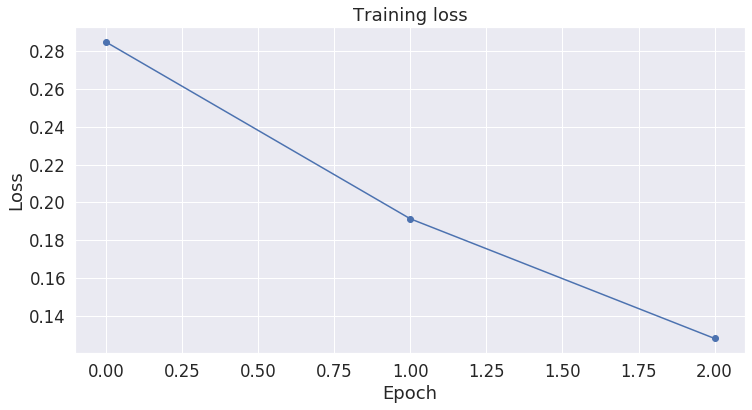

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

# Measuring the performance on test dataset

In [0]:
# Prediction on test set

#print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

def evaluation_summary(description, predictions, true_labels):
    print("Evaluation for: " + description)
    precision = precision_score(predictions, true_labels, average='macro')
    recall = recall_score(predictions, true_labels, average='macro')
    accuracy = accuracy_score(predictions, true_labels)
    f1 = fbeta_score(predictions, true_labels, 1, average='macro') #1 means f_1 measure
    print("Classifier '%s' has Acc=%0.3f P=%0.3f R=%0.3f F1=%0.3f" % (description,accuracy,precision,recall,f1))
    # Specify three digits instead of the default two.
    print(classification_report(predictions, true_labels, digits=3))
    print('\nConfusion matrix:\n',confusion_matrix(true_labels, predictions)) # Note the order here is true, predicted, odd.

In [0]:
prediction_list=[]
for preds in predictions:
  for i in np.argmax(preds,axis=1):
    prediction_list.append(i)

In [0]:
len(prediction_list)

10000

In [0]:
true_list=[]
for batch_labels in true_labels:
  for label in batch_labels:
    true_list.append(label)

In [0]:

evaluation_summary("Bert",  prediction_list, true_list)

Evaluation for: Bert
Classifier 'Bert' has Acc=0.904 P=0.878 R=0.880 F1=0.879
              precision    recall  f1-score   support

           0      0.821     0.826     0.823      2696
           1      0.936     0.934     0.935      7304

    accuracy                          0.904     10000
   macro avg      0.878     0.880     0.879     10000
weighted avg      0.905     0.904     0.905     10000


Confusion matrix:
 [[2226  485]
 [ 470 6819]]


### Logistic regression and tuning:

In [20]:
random_reviews.head()

,productId,reviewerID,reviewText,summary,overall,Class
189271,B006ON41FC,A2FT16E23VC4BJ,great little time killer with lots of mini goa...,fun app,5.0,1
232653,B007FY9ZWI,AK2RNPCHB83EW,I play bass guitar for my church. I needed a ...,Great Music Player,5.0,1
439701,B009XAJI8S,A10RV0FGPT0AYX,"So a few months back, I saw US TV Free feature...",Well...it's not TOO bad.,5.0,1
82502,B0052AZJV8,A1XDYXEK7HMQFS,I took it off I could not figure out how to us...,:-(,2.0,0
663441,B00F9WWIHW,A25ROTPGHBROH2,I truly loved it.it a great game for anyone wh...,ghoultastic!,5.0,1


In [0]:
from sklearn.model_selection import train_test_split
train_inputs, test_inputs, train_labels, test_labels = train_test_split(random_reviews, random_reviews['Class'].values, 
                                                            random_state=2018, test_size=0.2)

In [13]:

#!python -m spacy download en

import spacy

import sys
print(sys.version)

# Version checks
import importlib
def version_check(libname, min_version):
    m = importlib.import_module(libname)
    print ("%s version %s is" % (libname, m.__version__))
    print ("OK" if m.__version__ >= min_version 
           else "out-of-date. Please upgrade!")
    
version_check("spacy", "2.0")

# Load the small english model. 
# Disable the advanced NLP features in the pipeline for efficiency.
nlp = spacy.load('en_core_web_sm', disable=['ner'])
print(nlp.pipeline)
print(nlp.pipe_names)
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
# Verify they are empty.
print(nlp.pipeline)

#@Tokenize
def spacy_tokenize(string):
    tokens = list()
    doc = nlp(string)
    for token in doc:
        tokens.append(token)
    return tokens

#@Normalize
def normalize(tokens):
    normalized_tokens = list()
    for token in tokens:
        normalized = token.text.lower().strip()
        #print(normalized)
        if "_" in token.text:
            normalized_tokens.append(normalized)
        
        
        if ((token.is_alpha or token.is_digit )):
            normalized_tokens.append(normalized)
        
    return normalized_tokens
    

#@Tokenize and normalize
def tokenize_normalize(string):
    return normalize(spacy_tokenize(string))

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
spacy version 2.1.9 is
OK
[('tagger', <spacy.pipeline.pipes.Tagger object at 0x7fc56f708d68>), ('parser', <spacy.pipeline.pipes.DependencyParser object at 0x7fc56d0a4b88>)]
['tagger', 'parser']
[]


In [0]:
# TAD Lab 4 University Of Glasgow

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.    """

    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression  
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

# Specify parameters to tune
# Use names from the pipeline and argument names separated with: "___" string. 
# e.g. 'lr__max_iter': (100, 500) to search two values 100,500 for the "max_iter" parameter
# for the logistic regression.

# Parameters to tune.
params = {
    # Fill in the parameter for CountVectorizer with the binary parameter.
   'cv__binary': (True,False),
    'lr__C':[0.001,.01,0.1,1],
    #'cv__sublinear_tf':(True,False)
    
}


pipe_new = Pipeline([
    ('selector', ItemSelector(key='reviewText')),
    # Note: This keeps count weights, not one-hot; we'll tune this parameter next.
    ('cv', CountVectorizer(tokenizer=tokenize_normalize)),
    ('lr', LogisticRegression())])





# Pass in your pipeline, params (to tune), scoring, and split parameters here!
grid_search = GridSearchCV(estimator=pipe_new,param_grid=params, n_jobs=1, scoring='f1_macro', verbose=1, cv=3 )
print("Performing grid search...")



grid_search.fit(train_inputs,train_labels)


best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
    
    

In [19]:
print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(params.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

Best score: 0.799
Best parameters set:
	cv__binary: False
	lr__C: 0.1


## Retraining the model on C=0.1 and Binary =False

In [0]:
pipe_new = Pipeline([
    ('selector', ItemSelector(key='reviewText')),
    # Note: This keeps count weights, not one-hot; we'll tune this parameter next.
    ('cv', CountVectorizer(tokenizer=tokenize_normalize,binary=False)),
    ('lr', LogisticRegression(C=0.1, max_iter=500))])


pipe_new.fit(train_inputs,train_labels)

prediction= pipe_new.predict(test_inputs)

In [23]:

evaluation_summary("Logistic regression",  prediction, test_labels)

Evaluation for: Logistic regression
Classifier 'Logistic regression' has Acc=0.854 P=0.790 R=0.829 F1=0.806
              precision    recall  f1-score   support

           0      0.649     0.782     0.709      2271
           1      0.932     0.876     0.903      7729

    accuracy                          0.854     10000
   macro avg      0.790     0.829     0.806     10000
weighted avg      0.868     0.854     0.859     10000


Confusion matrix:
 [[1776  962]
 [ 495 6767]]


In [0]:
import matplotlib.pyplot as plt

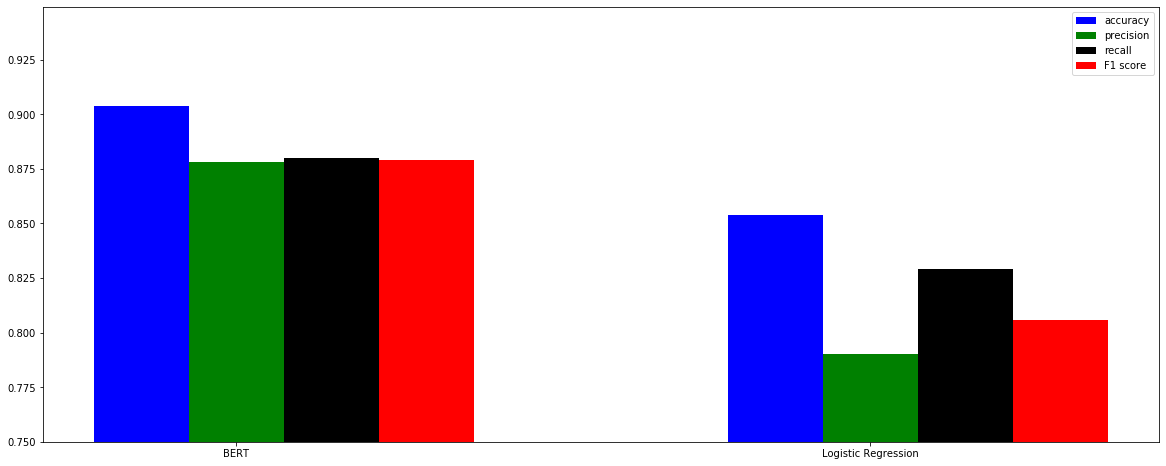

In [26]:
import numpy
index=numpy.array([1,3])
bw=0.3
acc=[0.904, 0.854]                                         #left is Bert and right is Logistic regression
p=[0.878, 0.790]
r=[0.880,0.829]
f1=[0.879,0.806]
plt.figure(figsize=(20,8))
plt.bar(index,acc,bw,color='b', label='accuracy')

plt.bar(index+bw,p,bw,color='g',label='precision')
plt.bar(index+2*bw,r,bw,color='k',label='recall')
plt.bar(index+3*bw,f1,bw,color='r',label='F1 score')
plt.xticks(index+bw,['BERT', 'Logistic Regression'])
plt.ylim(bottom=0.75)


plt.legend(loc=0)